Generate 3D conformation using 3 different methods :
* distance geometry : 
  1. The molecule’s distance bounds matrix is calculated based on the connection table and a set of rules.
  1. The bounds matrix is smoothed using a triangle-bounds smoothing algorithm.
  1. A random distance matrix that satisfies the bounds matrix is generated.
  1. This distance matrix is embedded in 3D dimensions (producing coordinates for each atom).
  1. The resulting coordinates are cleaned up somewhat using a crude force field and the bounds matrix : 
    1. UFF
    1. MMFF
* ETKDG

In [114]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

In [189]:
# Read the reference set of coordinates.
temp = Chem.SDMolSupplier('platinum_dataset_2017_01.sdf')
for m in temp:
    Chem.SanitizeMol(m)
plat_sdf = [x for x in temp if x is not None]

# Read smiles data
temp = Chem.SmilesMolSupplier('platinum_dataset_2017_01_fixed.smi', titleLine=False)
plat_smi = [x for x in temp if x is not None]

In [190]:
conf = {}

for method in ['uff','mmff','etkdg']:
    conf[method] = []
    for mol in plat_smi[:20]:
        m = Chem.AddHs(mol)

        if (method == 'uff' or method == 'mmff') :
            error = AllChem.EmbedMolecule(m)

            if error != 0:
                AllChem.EmbedMolecule(m, useRandomCoords=True)
            if   method == 'uff' : AllChem.UFFOptimizeMolecule(m)
            elif method == 'mmff': AllChem.MMFFOptimizeMolecule(m)
                    
        elif method == 'etkdg':
            AllChem.EmbedMolecule(m, AllChem.ETKDG())
        
        m2 = Chem.RemoveHs(m)
        Chem.SanitizeMol(m2)
        conf[method].append(m2)

In [67]:
#Draw.MolsToGridImage(conf['etkdg'],molsPerRow=6,subImgSize=(200,200))

In [5]:
rmsd = pd.DataFrame()
for method in ['uff','mmff','etkdg']:
    temp = []
    i = 0
    for sdf, smi in zip(plat_sdf, conf[method]):
        if i <= 20:
            val = AllChem.AlignMol(smi,sdf)
            temp.append(val)
            i+=1
        else:
            break
    temp = pd.DataFrame(temp)
    temp['method'] = method
    rmsd = pd.concat([rmsd,temp])

In [6]:
rmsd_ = pd.DataFrame()
for method in ['uff','mmff','etkdg']:
    temp = []
    i = 0
    for sdf, smi in zip(plat_sdf, conf[method]):
        if i <= 20:
            val = AllChem.GetBestRMS(smi,sdf)
            temp.append(val)
            i+=1
        else:
            break
    temp = pd.DataFrame(temp)
    temp['method'] = method
    rmsd_ = pd.concat([rmsd_,temp])

<IPython.core.display.Javascript object>


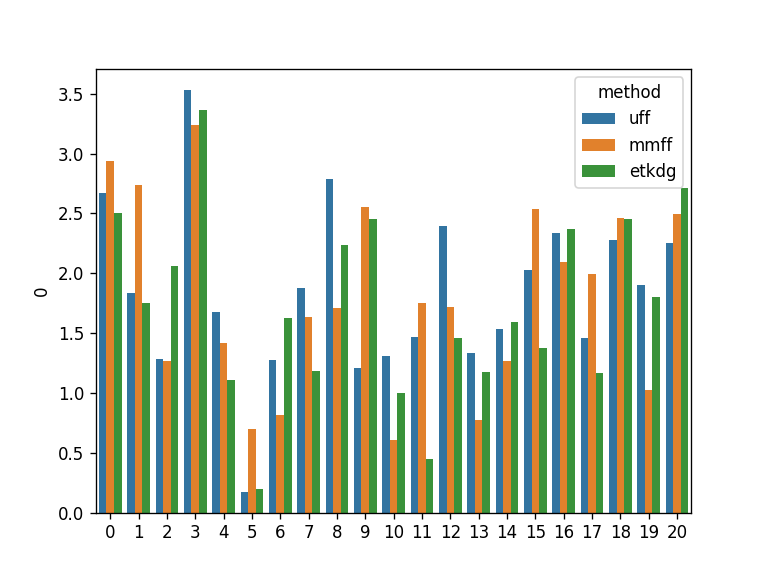

In [21]:
sns.barplot(x=rmsd.index,y=rmsd[0],data=rmsd, hue='method')

In [60]:
data = pd.DataFrame()
for method in ['uff','mmff','etkdg']:
    temp = rmsd.loc[rmsd['method'] == method]
    
    median = temp.median()[0]
    avg = temp.mean()[0]
    sem = temp.sem()[0]
    
    temp = pd.DataFrame([avg,sem,median], index=['avg','sem','median'])
    data = pd.concat([data,temp],axis=1)

In [62]:
data.columns=['uff','mmff','etkdg']

<IPython.core.display.Javascript object>


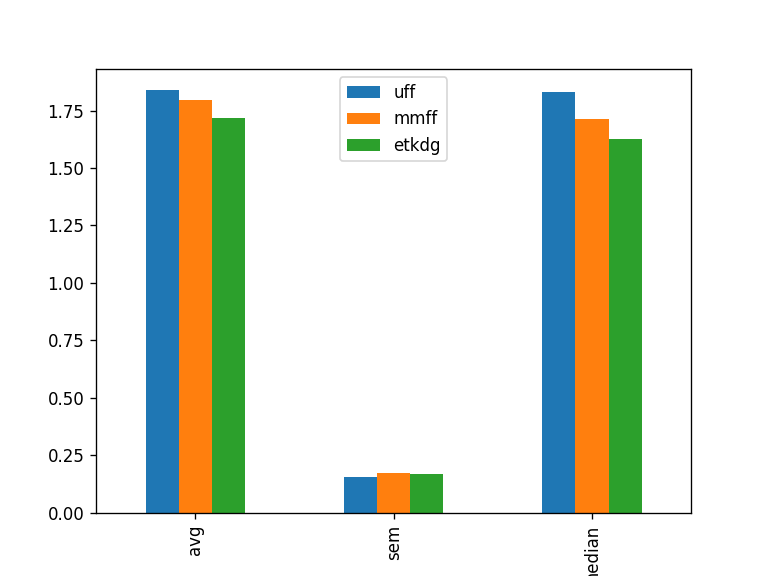

In [66]:
data.plot(kind='bar')

In [141]:
# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures

## With 4 threads it takes 11 seconds.
## 34.933u 0.188s 0:10.89 322.4%   0+0k 125+1io 0pf+0w
max_workers=8

def generate3D(mol):
    m = Chem.AddHs(mol)
    AllChem.EmbedMolecule(m, AllChem.ETKDG())
    m2 = Chem.RemoveHs(m)
    Chem.SanitizeMol(m2)
    return m2

In [163]:
conformers = []
for mol in plat_smi[:10]:
    conformers.append(generate3D(mol))

In [136]:
conformers = []
with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for mol in plat_smi:
        if mol:
            job = executor.submit(generate3D, mol)
            jobs.append(job)
            
    for job in futures. as_completed(jobs):
        conformers.append(job.result())

In [152]:
ex = futures.ThreadPoolExecutor(max_workers=max_workers)
results = ex.map(generate3D, plat_smi)
real_results = list(results)

In [185]:
def test_method(plat_sdf, conformers):
    rmsd = []
    for sdf, smi in zip(plat_sdf, conformers):
        try:
            val = AllChem.GetBestRMS(smi,sdf)
            rmsd.append(val)
        except ValueError:
            pass
    rmsd = pd.DataFrame(rmsd)
    return rmsd

rmsd = test_method(plat_sdf, real_results)
rmsd

,0
0,3.601028
1,1.860854
2,2.270536
3,2.972000
4,1.477633
5,0.686368
6,1.150120
7,1.241954
8,2.619014
9,1.155280


<IPython.core.display.Javascript object>


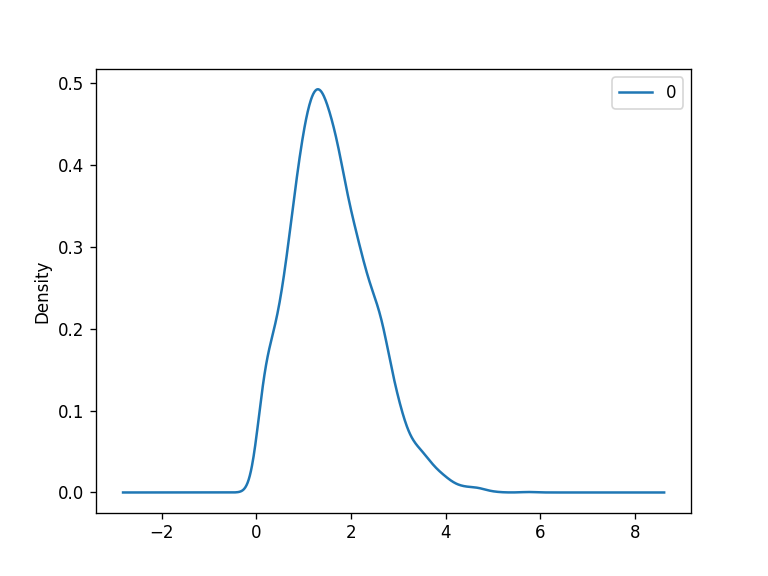

In [188]:
rmsd.plot(kind='kde')

In [182]:
AllChem.GetBestRMS(plat_sdf[1640],real_results[1640])

1.442229722732709

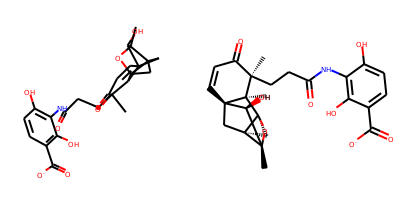

In [183]:
Draw.MolsToGridImage([plat_sdf[1641],real_results[1641]],molsPerRow=2,subImgSize=(200,200))